# Runtime Exps

In [86]:
import os
import time
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.autonotebook import tqdm

from emc.estimator.EMC import EMC
from emc.generator.markov import MarkovianSwitchingSystem
from emc.utils.plot import get_mpl_conf_path, set_size

## Generate Data

In [4]:
alphabet_cardinality = 4
mode_process_order = 1
subprocess_order = 1
number_of_subprocesses = 5
number_of_regimes = 2
regime_length_bounds_list = [[500,501]]
number_of_runs = [1]

for regime_length_bounds in regime_length_bounds_list:

    desc = f"{regime_length_bounds[0]}:{regime_length_bounds[1]}".ljust(10)
    for run_count in tqdm(range(np.sum(number_of_runs)), desc=desc):

        # generate MSS, mode and symbol sequences
        mss_ins = MarkovianSwitchingSystem(
            alphabet_cardinality=alphabet_cardinality,
            mode_process_order=mode_process_order,
            subprocess_order=subprocess_order,
            number_of_subprocesses=number_of_subprocesses,
            rng_or_seed=run_count
        )
        mss_ins.generate_subprocess_sequence(
            number_of_regimes=number_of_regimes,
            avoid_loops=True
        )
        symbol_sequence = mss_ins.generate_symbol_sequence(
            regime_length_bounds=regime_length_bounds
        )

        run_params = {
            "subprocess_sequence": mss_ins.subprocess_sequence,
            "regime_lengths": mss_ins.regime_lengths,
            "change_points": np.cumsum(mss_ins.regime_lengths),
            "subprocesses": mss_ins.subprocesses,
            "subprocess_sequence_full": np.repeat(mss_ins.subprocess_sequence, mss_ins.regime_lengths),
            "symbol_sequence": symbol_sequence
        }

print(len(symbol_sequence))

500:501   :   0%|          | 0/1 [00:00<?, ?it/s]

1000


## Runtime Test for Update Equation

### Markov Order (k) vs Time

  0%|          | 0/100 [00:00<?, ?it/s]

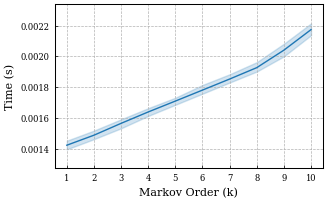

In [87]:
S = run_params["symbol_sequence"]
ks = range(1,11)
m = 4
lambda_ = 0.95
exec_times = []

for run_count in tqdm(range(100)):
    for k in ks:
        P = 1/m * np.ones(shape=np.repeat(m, k+1))
        cnd = deque(maxlen=k)
        start = time.time()
        # ---
        for s in S:
            if len(cnd) == k:
                P[tuple(cnd)] *= lambda_
                P[tuple(cnd)][s] += (1 - lambda_)
            cnd.append(s)
        # ---
        end = time.time()
        elapsed = end - start
        exec_times.append({"k":k, "m":m, "time": elapsed})

exec_times_df = pd.DataFrame.from_records(exec_times)

plt.style.use("default")
plt.style.use(get_mpl_conf_path("pub"))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=set_size(**{"width":"generic_paper", "aspect_ratio":"golden", "fraction":0.5}))
sns.lineplot(data=exec_times_df, x="k", y="time", errorbar="pi")
ax.set_xlabel("Markov Order (k)")
ax.set_ylabel("Time (s)")
ax.set_xticks(ks)
ax.margins(x=0.05, y=0.15)
fig_path = os.path.join("eq_kt.pdf")
fig.savefig(fig_path, bbox_inches="tight")
plt.show()

### Number of States (m) vs Time

  0%|          | 0/100 [00:00<?, ?it/s]

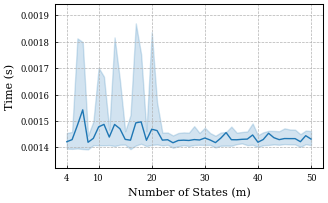

In [88]:
S = run_params["symbol_sequence"]
k = 1
ms = range(4,51)
lambda_ = 0.95
exec_times = []

for run_count in tqdm(range(100)):
    for m in ms:
        P = 1/m * np.ones(shape=np.repeat(m, k+1))
        cnd = deque(maxlen=k)
        start = time.time()
        # ---
        for s in S:
            if len(cnd) == k:
                P[tuple(cnd)] *= lambda_
                P[tuple(cnd)][s] += (1 - lambda_)
            cnd.append(s)
        # ---
        end = time.time()
        elapsed = end - start
        exec_times.append({"k":k, "m":m, "time": elapsed})

exec_times_df = pd.DataFrame.from_records(exec_times)

plt.style.use("default")
plt.style.use(get_mpl_conf_path("pub"))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=set_size(**{"width":"generic_paper", "aspect_ratio":"golden", "fraction":0.5}))
sns.lineplot(data=exec_times_df, x="m", y="time", errorbar="pi")
ax.set_xlabel("Number of States (m)")
ax.set_ylabel("Time (s)")
ax.set_xticks([4,10,20,30,40,50])
ax.margins(x=0.05, y=0.15)
fig_path = os.path.join("eq_mt.pdf")
fig.savefig(fig_path, bbox_inches="tight")
plt.show()

## Runtime Test for End-to-end EMC

### Markov Order (k) vs Time

  0%|          | 0/100 [00:00<?, ?it/s]

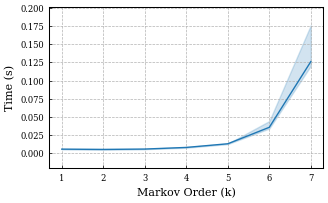

In [89]:
ks = range(1,8)
m = 4

exec_times = []

for run_count in tqdm(range(100)):
    for k in ks:
        start = time.time()
        emc_ins = EMC(
            alpha=m,
            order=k,
            lambda_=[0.94, 0.95],
            beta=0,
            delta=[0.3, 0.2],
            eta=[0.5, 0.25],
            tau=100
        )
        emc_ins.process_sequence(run_params["symbol_sequence"], progress=False)
        end = time.time()
        elapsed = end - start
        exec_times.append({"k":k, "m":m, "time": elapsed})

exec_times_df = pd.DataFrame.from_records(exec_times)

plt.style.use("default")
plt.style.use(get_mpl_conf_path("pub"))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=set_size(**{"width":"generic_paper", "aspect_ratio":"golden", "fraction":0.5}))
sns.lineplot(data=exec_times_df, x="k", y="time", errorbar="pi")
ax.set_xlabel("Markov Order (k)")
ax.set_ylabel("Time (s)")
ax.set_xticks(ks)
ax.margins(x=0.05, y=0.15)
fig_path = os.path.join("e2e_kt.pdf")
fig.savefig(fig_path, bbox_inches="tight")
plt.show()

### Number of States (m) vs Time

  0%|          | 0/100 [00:00<?, ?it/s]

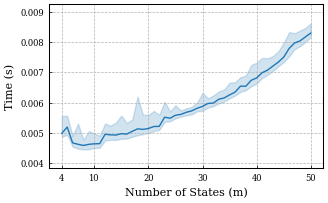

In [91]:
ms = range(4,51)
k = 1

exec_times = []

for run_count in tqdm(range(100)):
    for m in ms:
        start = time.time()
        emc_ins = EMC(
            alpha=m,
            order=k,
            lambda_=[0.94, 0.95],
            beta=0,
            delta=[0.3, 0.2],
            eta=[0.5, 0.25],
            tau=100
        )
        emc_ins.process_sequence(run_params["symbol_sequence"], progress=False)
        end = time.time()
        elapsed = end - start
        exec_times.append({"k":k, "m":m, "time": elapsed})

exec_times_df = pd.DataFrame.from_records(exec_times)

plt.style.use("default")
plt.style.use(get_mpl_conf_path("pub"))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=set_size(**{"width":"generic_paper", "aspect_ratio":"golden", "fraction":0.5}))
sns.lineplot(data=exec_times_df, x="m", y="time", errorbar="pi")
ax.set_xlabel("Number of States (m)")
ax.set_ylabel("Time (s)")
ax.set_xticks([4,10,20,30,40,50])
ax.margins(x=0.05, y=0.15)
fig_path = os.path.join("e2e_mt.pdf")
fig.savefig(fig_path, bbox_inches="tight")
plt.show()